<a href="https://colab.research.google.com/github/seanrjohnson/protein_scoring/blob/main/colab_notebooks/Protein_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Protein Metrics

This notebook calculates various sequence- and structure-based quality scores for proteins, such as those produced by generative models. Many different kinds of metrics can be calculated. For all of the metrics, proteins with higher scores (closer to zero for negative numbers) are predicted to be more likely to fold and have function than proteins with lower scores.

**inputs**: Please provide protein sequences in fasta format, AlphaFold2-predicted structures, and/or reference protein sequences in fasta format as appropriate (see sections below).

**outputs**: A comma-separated values (csv) text file with the calculated metrics.


## Setup

In [ ]:
%%capture cap --no-stderr
#@title 1. Install dependencies and set up directories

# set up directories
!rm -r sample_data
!mkdir -p pdbs target_seqs reference_seqs

!mkdir -p /opt/bin

#install esm
!pip -q install  git+https://github.com/facebookresearch/esm.git@e5e7b06b9a093706607c229ab1c5c9821806814d

#install hmmer, mafft, emboss, biotite, and sequence-models
!apt-get -qq update > /dev/null
!apt-get -qq install  hmmer mafft emboss > /dev/null
!pip -q install  biotite pytest-datadir sequence-models > /dev/null

#install fasta3
!wget https://github.com/wrpearson/fasta36/releases/download/v36.3.8i_14-Nov-2020/fasta-36.3.8i-linux64.tar.gz > /dev/null
!tar xf fasta-36.3.8i-linux64.tar.gz > /dev/null
!mv fasta-36.3.8i/bin/* /opt/bin
!rm -r fasta*


#install protein_gibbs_sampler
!git clone https://github.com/seanrjohnson/protein_gibbs_sampler > /dev/null
!cd protein_gibbs_sampler ; git checkout 7de11ff63f7dca3cb52ef84109152ac8f988b7a0 2>&1 > /dev/null ; yes | pip install -q --no-dependencies . > /dev/null
!yes | pip -q install  biopython~=1.79 pytest-datadir~=1.4.1 > /dev/null


#install ProteinMPNN
!git clone https://github.com/dauparas/ProteinMPNN.git > /dev/null
!cd ProteinMPNN ; git checkout 0a721279f6706478193f50dff9c1e5ff96214778 > /dev/null


### FROM ESM-IF example notebook https://github.com/facebookresearch/esm/blob/e5e7b06b9a093706607c229ab1c5c9821806814d/examples/inverse_folding/notebook.ipynb
import torch
def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html > /dev/null
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html > /dev/null
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html > /dev/null
!pip install -q torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html > /dev/null
!pip install -q torch-geometric > /dev/null
### END OF CODE FROM ESM-IF

#biotite version bugfix
!pip install biotite==0.41.2


In [ ]:
#@title 2. Reset calculated metrics (creates a new datastructure to store results, clearing any existing results)

results = dict()
device = 'cuda:0'

from google.colab import files
import os
import re
import torch

#from sequence_models.utils import parse_fasta
from typing import List
from pgen.utils import parse_fasta
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from pathlib import Path
from glob import glob
from random import randrange
import esm
from biotite.structure.io import pdb
from biotite.structure import get_residue_count
from biotite.structure.residues import get_residues
from biotite.sequence import ProteinSequence
import tempfile
from Bio.Align import substitution_matrices
import subprocess
from dataclasses import dataclass

from sequence_models.pretrained import load_model_and_alphabet
from sequence_models.pdb_utils import parse_PDB, process_coords

def residues_in_pdb(pdb_path):
    with open(pdb_path) as f:
        pdb_file = pdb.PDBFile.read(pdb_path)
        atoms  = pdb_file.get_structure()
    return get_residue_count(atoms)

gap_open=10
gap_extend=2

def add_metric(metrics_dict, protein_name, metric_name, value):
  if protein_name not in metrics_dict:
    metrics_dict[protein_name] = dict()
  metrics_dict[protein_name][metric_name] = value

def get_pdb_sequence(pdb_path):
    with open(pdb_path) as f:
        pdb_file = pdb.PDBFile.read(pdb_path)
        atoms  = pdb_file.get_structure()
        residues = get_residues(atoms)[1]
    return ''.join([ProteinSequence.convert_letter_3to1(r) for r in residues])

with open("/tmp/PFASUM15.mat", "w") as f:
  f.write("""    A   R   N   D   C   Q   E   G   H   I   L   K   M   F   P   S   T   W   Y   V   B   Z   J   X   *
A   3  -1  -1  -1   0  -1   0   1  -1   0   0  -1  -1  -2   0   1   0  -2  -2   1  -7  -6  -6 -26  -6
R  -1   6   1   0  -3   2   1  -1   0  -4  -3   4  -2  -4   0   0   1  -3  -3  -3  -5  -4 -10 -26  -6
N  -1   1   6   3  -3   2   1   1   3  -5  -4   1  -1  -4   0   2   0  -5  -2  -4  -4  -4 -10 -26  -6
D  -1   0   3   8  -3   1   3   0   1  -5  -5   1  -5  -5   0   1   0  -5  -4  -4  -3  -3 -11 -27  -6
C   0  -3  -3  -3  16  -2  -1   0  -1   0   0  -4   2   1  -2   0   0   0  -2   1  -9  -7  -6 -26  -6
Q  -1   2   2   1  -2   5   3   0   1  -4  -4   2  -2  -3  -1   1   1  -1  -3  -3  -5  -5 -10 -26  -6
E   0   1   1   3  -1   3   6   0   1  -5  -4   3  -3  -6   0   0   0  -3  -3  -4  -4  -5 -10 -26  -6
G   1  -1   1   0   0   0   0   9   0  -4  -4   0  -2  -3   0   1  -1  -2  -4  -3  -5  -6 -10 -27  -6
H  -1   0   3   1  -1   1   1   0  10  -4  -3   1  -2  -1  -1   0   0   0   2  -2  -4  -5  -9 -26  -6
I   0  -4  -5  -5   0  -4  -5  -4  -4   5   4  -4   3   3  -4  -3  -1  -1   0   5 -11 -10  -3 -26  -6
L   0  -3  -4  -5   0  -4  -4  -4  -3   4   5  -4   2   3  -3  -3  -2   1   1   3 -10 -10  -5 -27  -6
K  -1   4   1   1  -4   2   3   0   1  -4  -4   5  -2  -4   0   1   0  -4  -2  -4  -5  -3 -10 -26  -6
M  -1  -2  -1  -5   2  -2  -3  -2  -2   3   2  -2   8   2  -2  -2   0   2   1   2  -9  -9  -4 -26  -6
F  -2  -4  -4  -5   1  -3  -6  -3  -1   3   3  -4   2   8  -3  -4  -2   5   5   1 -11 -11  -3 -26  -6
P   0   0   0   0  -2  -1   0   0  -1  -4  -3   0  -2  -3  12   0   0  -3  -2  -3  -6  -6 -10 -27  -6
S   1   0   2   1   0   1   0   1   0  -3  -3   1  -2  -4   0   4   2  -3  -2  -2  -5  -5  -9 -26  -6
T   0   1   0   0   0   1   0  -1   0  -1  -2   0   0  -2   0   2   3  -3  -1   0  -6  -6  -7 -26  -6
W  -2  -3  -5  -5   0  -1  -3  -2   0  -1   1  -4   2   5  -3  -3  -3  20   6  -2 -11  -8  -6 -27  -6
Y  -2  -3  -2  -4  -2  -3  -3  -4   2   0   1  -2   1   5  -2  -2  -1   6  10   0  -9  -9  -6 -26  -6
V   1  -3  -4  -4   1  -3  -4  -3  -2   5   3  -4   2   1  -3  -2   0  -2   0   5 -10 -10  -2 -26  -6
B  -7  -5  -4  -3  -9  -5  -4  -5  -4 -11 -10  -5  -9 -11  -6  -5  -6 -11  -9 -10  -5 -10 -17 -32  -6
Z  -6  -4  -4  -3  -7  -5  -5  -6  -5 -10 -10  -3  -9 -11  -6  -5  -6  -8  -9 -10 -10  -6 -16 -32  -6
J  -6 -10 -10 -11  -6 -10 -10 -10  -9  -3  -5 -10  -4  -3 -10  -9  -7  -6  -6  -2 -17 -16  -6 -33  -6
X -26 -26 -26 -27 -26 -26 -26 -27 -26 -26 -27 -26 -26 -26 -27 -26 -26 -27 -26 -26 -32 -32 -33 -40  -6
*  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6  -6   1""")

with open("/tmp/BLOSUM62.mat", "w") as f:
  f.write("""   A  R  N  D  C  Q  E  G  H  I  L  K  M  F  P  S  T  W  Y  V  B  Z  X  *
A  4 -1 -2 -2  0 -1 -1  0 -2 -1 -1 -1 -1 -2 -1  1  0 -3 -2  0 -2 -1  0 -4
R -1  5  0 -2 -3  1  0 -2  0 -3 -2  2 -1 -3 -2 -1 -1 -3 -2 -3 -1  0 -1 -4
N -2  0  6  1 -3  0  0  0  1 -3 -3  0 -2 -3 -2  1  0 -4 -2 -3  3  0 -1 -4
D -2 -2  1  6 -3  0  2 -1 -1 -3 -4 -1 -3 -3 -1  0 -1 -4 -3 -3  4  1 -1 -4
C  0 -3 -3 -3  9 -3 -4 -3 -3 -1 -1 -3 -1 -2 -3 -1 -1 -2 -2 -1 -3 -3 -2 -4
Q -1  1  0  0 -3  5  2 -2  0 -3 -2  1  0 -3 -1  0 -1 -2 -1 -2  0  3 -1 -4
E -1  0  0  2 -4  2  5 -2  0 -3 -3  1 -2 -3 -1  0 -1 -3 -2 -2  1  4 -1 -4
G  0 -2  0 -1 -3 -2 -2  6 -2 -4 -4 -2 -3 -3 -2  0 -2 -2 -3 -3 -1 -2 -1 -4
H -2  0  1 -1 -3  0  0 -2  8 -3 -3 -1 -2 -1 -2 -1 -2 -2  2 -3  0  0 -1 -4
I -1 -3 -3 -3 -1 -3 -3 -4 -3  4  2 -3  1  0 -3 -2 -1 -3 -1  3 -3 -3 -1 -4
L -1 -2 -3 -4 -1 -2 -3 -4 -3  2  4 -2  2  0 -3 -2 -1 -2 -1  1 -4 -3 -1 -4
K -1  2  0 -1 -3  1  1 -2 -1 -3 -2  5 -1 -3 -1  0 -1 -3 -2 -2  0  1 -1 -4
M -1 -1 -2 -3 -1  0 -2 -3 -2  1  2 -1  5  0 -2 -1 -1 -1 -1  1 -3 -1 -1 -4
F -2 -3 -3 -3 -2 -3 -3 -3 -1  0  0 -3  0  6 -4 -2 -2  1  3 -1 -3 -3 -1 -4
P -1 -2 -2 -1 -3 -1 -1 -2 -2 -3 -3 -1 -2 -4  7 -1 -1 -4 -3 -2 -2 -1 -2 -4
S  1 -1  1  0 -1  0  0  0 -1 -2 -2  0 -1 -2 -1  4  1 -3 -2 -2  0  0  0 -4
T  0 -1  0 -1 -1 -1 -1 -2 -2 -1 -1 -1 -1 -2 -1  1  5 -2 -2  0 -1 -1  0 -4
W -3 -3 -4 -4 -2 -2 -3 -2 -2 -3 -2 -3 -1  1 -4 -3 -2 11  2 -3 -4 -3 -2 -4
Y -2 -2 -2 -3 -2 -1 -2 -3  2 -1 -1 -2 -1  3 -3 -2 -2  2  7 -1 -3 -2 -1 -4
V  0 -3 -3 -3 -1 -2 -2 -3 -3  3  1 -2  1 -1 -2 -2  0 -3 -1  4 -3 -2 -1 -4
B -2 -1  3  4 -3  0  1 -1  0 -3 -4  0 -3 -3 -2  0 -1 -4 -3 -3  4  1 -1 -4
Z -1  0  0  1 -3  3  4 -2  0 -3 -3  1 -1 -3 -1  0 -1 -3 -2 -2  1  4 -1 -4
X  0 -1 -1 -1 -2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -2  0  0 -2 -1 -1 -1 -1 -1 -4
* -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4  1
""")

with open("/tmp/extract_mif.py", "w") as f:
  f.write("""import argparse

import torch.cuda
from tqdm import tqdm
import pandas as pd
import numpy as np

from sequence_models.utils import parse_fasta
from sequence_models.pretrained import load_model_and_alphabet
from sequence_models.pdb_utils import parse_PDB, process_coords


parser = argparse.ArgumentParser()
parser.add_argument('model')
parser.add_argument('tsv_fpath')
parser.add_argument('out_dir')
parser.add_argument('result')
parser.add_argument('--include', nargs='*', default=['mean'])
parser.add_argument('--device', default=None)
args = parser.parse_args()

# Check inputs
if args.model not in ['mif', 'mifst']:
    raise ValueError("Valid models ars 'mif' and 'mifst'.")
if args.result == 'logits':
    for inc in args.include:
        if inc not in ['per_tok', 'logp']:
            raise ValueError("logits can be included as 'per_tok' or as 'logp'.")
elif args.result == 'repr':
    for inc in args.include:
        if inc not in ['per_tok', 'mean']:
            raise ValueError("repr can be included as 'per_tok' or as 'mean'.")
else:
    raise ValueError("Valid results ars 'repr' and 'logits'.")

# load model
print('Loading model...')
model, collater = load_model_and_alphabet(args.model)
# detect device and move model to it
if args.device is None:
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
else:
    device = torch.device(args.device)
model = model.to(device)
# load data
print('Loading data...')
df = pd.read_table(args.tsv_fpath).reset_index()
if 'logp' in args.include:
    logps = np.empty(len(df))
with tqdm(total=len(df)) as pbar:
    for i, row in df.iterrows():
        seq = row['sequence']
        pdb = row['pdb']
        name = row['name']
        coords, wt, _ = parse_PDB(pdb)
        coords = {
            'N': coords[:, 0],
            'CA': coords[:, 1],
            'C': coords[:, 2]
        }
        dist, omega, theta, phi = process_coords(coords)
        batch = [[seq, torch.tensor(dist, dtype=torch.float),
                  torch.tensor(omega, dtype=torch.float),
                  torch.tensor(theta, dtype=torch.float), torch.tensor(phi, dtype=torch.float)]]
        src, nodes, edges, connections, edge_mask = collater(batch)
        src = src.to(device)
        nodes = nodes.to(device)
        edges = edges.to(device)
        connections = connections.to(device)
        edge_mask = edge_mask.to(device)
        rep = model(src, nodes, edges, connections, edge_mask, result=args.result)[0]
        if args.result == 'repr':
            if 'mean' in args.include:
                torch.save(rep.mean(dim=0).detach().cpu(),
                           args.out_dir + '_'.join([name, args.model, 'mean']) + '.pt')
            if 'per_tok' in args.include:
                torch.save(rep.detach().cpu(),
                           args.out_dir + '_'.join([name, args.model, 'per_tok']) + '.pt')
        else:
            if 'logp' in args.include:
                rep = rep.log_softmax(dim=-1)
                logps[i] = rep[torch.arange(len(src[0])), src].mean().detach().cpu().numpy()
            if 'per_tok' in args.include:
                torch.save(rep.detach().cpu(), args.out_dir + '_'.join([name, args.model, 'logits']) + '.pt')
        pbar.update(1)
    if 'logp' in args.include:
        df['logp'] = logps
        out_fpath = args.out_dir + args.model + '_logp.tsv'
        print('Writing results to ' + out_fpath)
        df = df.to_csv(out_fpath, index=False, sep="\t")
  """)

with open("/tmp/extract.py", "w") as f:
  f.write("""import argparse

import torch.cuda
from tqdm import tqdm
import numpy as np
import pandas as pd

from sequence_models.utils import parse_fasta
from sequence_models.pretrained import load_model_and_alphabet

parser = argparse.ArgumentParser()
parser.add_argument('model')
parser.add_argument('in_fpath')
parser.add_argument('out_dir')
parser.add_argument('--repr_layers', nargs='*', default=[-1])
parser.add_argument('--include', nargs='*', default=['mean'])
parser.add_argument('--device', default=None)
parser.add_argument('--batchsize', default=1, type=int)
args = parser.parse_args()

# load model
print('Loading model...')
model, collater = load_model_and_alphabet(args.model)
# detect device and move model to it
if args.device is None:
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
else:
    device = torch.device(args.device)
model = model.to(device)
# load data
print('Loading data...')
seqs, names = parse_fasta(args.in_fpath, return_names=True)
ells = [len(s) for s in seqs]
seqs = [[s] for s in seqs]
n_total = len(seqs)
repr_layers = []
for r in args.repr_layers:
    if r == 'logits':
        logits = True
    else:
        repr_layers.append(int(r))
if 'logp' in args.include:
    logps = np.empty(len(seqs))
with tqdm(total=n_total) as pbar:
    for i in range(0, n_total, args.batchsize):
        start = i
        end = start + args.batchsize
        bs = seqs[start:end]
        bn = names[start:end]
        bl = ells[start:end]
        # tokenize
        x = collater(bs)[0].to(device)
        # pass through the model
        results = model(x, repr_layers=repr_layers, logits=logits)
        if 'representations' in results:
            for layer, rep in results['representations'].items():
                for r, ell, name in zip(rep, bl, bn):
                    r = r[:ell]
                    if 'mean' in args.include:
                        torch.save(r.mean(dim=0).detach().cpu(),
                                   args.out_dir + '_'.join([name, args.model, str(layer), 'mean']) + '.pt')
                    if 'per_tok' in args.include:
                        torch.save(r.detach().cpu(),
                                   args.out_dir + '_'.join([name, args.model, str(layer), 'per_tok']) + '.pt')
        if logits:
            rep = results['logits']
            for r, ell, name, src in zip(rep, bl, bn, x):
                if 'per_tok' in args.include:
                    r = r[:ell]
                    torch.save(r.detach().cpu(), args.out_dir + '_'.join([name, args.model, 'logits']) + '.pt')
                if 'logp' in args.include:
                    r = r.log_softmax(dim=-1)[:ell]
                    # print(src.shape, r.shape)
                    logps[i] = r[torch.arange(len(src)), src].mean().detach().cpu().numpy()
        pbar.update(len(bs))
    if 'logp' in args.include:
        df = pd.DataFrame()
        df['name'] = names
        df['sequence'] = [s[0] for s in seqs]
        df['logp'] = logps
        out_fpath = args.out_dir + args.model + '_logp.tsv'
        print('Writing results to ' + out_fpath)
        df = df.to_csv(out_fpath, index=False, sep="\t")
""")

### 3. Upload files

Different files are required depending on which kinds of metrics you want to calculate.

Please upload protein PDB files or protein fasta files to the appropriate directories in `/content`

- Structures as PDB files (used for structure metrics).
   - In this notebook we assume every strucure has a single chain, chain A.
   - pLDDT score assumes that the scores are stored in the b-factor field of the PDB file, which is the case for PDB files generated by AlphaFold2.
- Target sequences (used for single-sequence and alignment-based metrics)
  - If the directory contains more than one fasta file, metrics will be calculated for all sequences from all files in the directory.
- Reference sequences (used for alignment-based metrics)
  - If the directory contains more than one fasta file, all of them will be used as reference sequences.

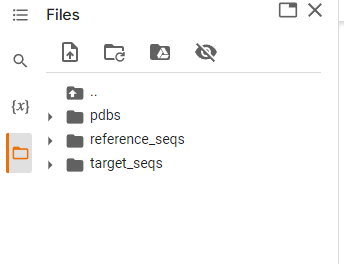




## Calculate Metrics

In [ ]:
#@title ## Structure Metrics

#@markdown Requires PDB uploaded files. All metrics will execute on all uploaded PDB files.

#@markdown __ESM-IF, ProteinMPNN, MIF-ST__

#@markdown The proteinMPNN and ESM-IF scores are the average log likelihood of the query residues. The ProteinMPNN score calculation is performed using the --score_only option of the protein_mpnn_run.py script from the ProteinMPNN repository (https://github.com/dauparas/ProteinMPNN). The ProteinMPNN score is multiplied by -1 so that higher is better, like with other metrics. The ESM-IF score is calculated using the esm.inverse_folding.util.score_sequence function from the ESM repository (https://github.com/facebookresearch/esm). The MIF-ST score is calculated using the extract_mif.py script from the Protein Sequence Models repository (https://github.com/microsoft/protein-sequence-models).

#@markdown __AlphaFold2 pLDDT__

#@markdown Average taken from the b-factors in AlphaFold2-produced pdb files.

#@markdown

#@markdown ### __Metrics__
# CHECKBOXES
ESM_IF = True #@param {type:"boolean"}
ProteinMPNN = True #@param {type:"boolean"}
MIF_ST = True #@param {type:"boolean"}
AlphaFold2_pLDDT = True #@param {type:"boolean"}


# ESM-IF
if ESM_IF: #TODO: move to GPU? Maybe spin off into a subprocess when moving to GPU, to avoid memory leaks?
  esm_if_model, esm_if_alphabet = esm.pretrained.esm_if1_gvp4_t16_142M_UR50()
  # esm_if_model = esm_if_model.to(device) # TODO: for some reason it crashes when I move it to the GPU
  esm_if_model.eval()
        # with open(output[0],'w') as f:
        #     f.write('id,esm-if\n')
  for pdb_file in glob("/content/pdbs/*.pdb"):
    fstem = Path(pdb_file).stem
    name = fstem
    coords, seq = esm.inverse_folding.util.load_coords(pdb_file, "A")
    ll, _ = esm.inverse_folding.util.score_sequence(
    esm_if_model, esm_if_alphabet, coords, str(seq))
    add_metric(results, name, "ESM-IF", ll)
  del esm_if_model
  del esm_if_alphabet
# ProteinMPNN
if ProteinMPNN:
  with tempfile.TemporaryDirectory() as output_dir:
    for i, pdb_file in enumerate(glob("/content/pdbs/*.pdb")):
      command_line_arguments=[
      "python",
      "ProteinMPNN/vanilla_proteinmpnn/protein_mpnn_run.py",
      "--pdb_path", pdb_file,
      "--pdb_path_chains", "A",
      "--score_only", "1",
      "--save_score", "1",
      "--out_folder", output_dir,
      "--batch_size", "1"
      ]
      fstem = Path(pdb_file).stem
      name = fstem
      outfile = output_dir + f"outfile_{i}.txt"
      with open(outfile,"w") as fh:
        proc = subprocess.run(command_line_arguments, stdout=subprocess.PIPE, check=True)
        print(proc.stdout.decode('utf-8'), file=fh)
      with open(outfile,"r") as score_file_h:
        score_file_lines = score_file_h.readlines()
      score_line = score_file_lines[-2].split(",")
      score_parts = score_line[1].strip().split(": ")
      assert score_parts[0] == "mean"
      score = -1 * float(score_parts[1])
      add_metric(results, name, "ProteinMPNN", score)

 # MIF-ST

if MIF_ST:
  with tempfile.TemporaryDirectory() as output_dir:
    spec_file_path = output_dir + "/spec_file.tsv"
    with open(spec_file_path, 'w') as f:
      f.write('name\tsequence\tpdb\n')
      for pdb_file in glob("/content/pdbs/*.pdb"):
        seq = get_pdb_sequence(pdb_file)
        name = Path(pdb_file).stem
        f.write(name + '\t' + seq + '\t' + pdb_file + '\n')
    #print(spec_file_path)
    proc = subprocess.run(['python', "/tmp/extract_mif.py", "mifst", spec_file_path, output_dir + "/", "logits", "--include", "logp", "--device", device], stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
    # print(proc.stderr.decode("utf-8"))
    # print(proc.stdout.decode("utf-8"))
    df = pd.read_table(output_dir + '/mifst_logp.tsv')
    df = df.rename(columns={'name': 'id', 'logp': 'mifst_logp'}, )
    for _, row in df.iterrows():
      add_metric(results, row["id"], "MIF-ST", row["mifst_logp"])



# pLDDT
if AlphaFold2_pLDDT:
  for pdb_file in glob("/content/pdbs/*.pdb"):
    fstem = Path(pdb_file).stem
    name = fstem
    pdb_file = pdb.PDBFile.read(pdb_file)
    atoms = pdb_file.get_structure(extra_fields = ['b_factor'])
    prev_residue = -1
    plddt_sum = 0
    residue_count = 0
    for a in atoms[0]:
      if a.res_id != prev_residue:
        prev_residue = a.res_id
        residue_count += 1
        plddt_sum += a.b_factor
    add_metric(results, name, "AlphaFold2 pLDDT", plddt_sum/residue_count)


In [ ]:
#@title Single-sequence metrics

#@markdown This might take a while the first execution because it needs to download the ESM-1v weights.

#@markdown __ESM-1v, ESM-1v mask6, CARP-640m__

#@markdown Scores calculated from the ESM-1v and CARP-640M models are the average of the log probabilities of the amino acid in each position. Without masking, this calculation can be done with a single forward pass over each sequence. With partial masking, it can be done in a number of passes equal to 1 / masked_fraction. At the most extreme each position could be masked one at a time. We found that masking in six passes, with the masked positions at a regular interval that shifts on every pass gave scores nearly equivalent to masking one position at a time. Furthermore, when no masking was applied, the scores were shifted towards zero but still strongly correlated with the masked scores. Therefore, we used ESM-1v and CARP-640M scores calculated in one pass without any masking.

#@markdown __repeat 1, 2, 3, 4__

#@markdown Scores are calculated for the longest single amino acid repeat, the longest 2-mer, 3-mer, and 4-mer repeat in each sequence. The score is calculated as -1 * the number of repeat units. So the sequence MAAAAAAI has a single amino acid repeat score of -6, a 2-mer score of -3, a 3-mer score of -2, and a 4-mer score of -1.

#@markdown ### __Metrics__
# CHECKBOXES
CARP_640m_logp = True #@param {type:"boolean"}
ESM_1v = True #@param {type:"boolean"}
ESM_1v_mask6 = True #@param {type:"boolean"}
repeat_1 = True #@param {type:"boolean"}
repeat_2 = True #@param {type:"boolean"}
repeat_3 = True #@param {type:"boolean"}
repeat_4 = True #@param {type:"boolean"}

target_seqs_file = "/tmp/target_seqs.fasta"
with open(target_seqs_file,"w") as fh:
  for target_fasta in glob("/content/target_seqs/*"):
    for name, seq in zip(*parse_fasta(target_fasta, return_names=True, clean="unalign")):
      print(f">{name}\n{seq}", file=fh)

#CARP
if CARP_640m_logp:
  with tempfile.TemporaryDirectory() as output_dir:
    proc = subprocess.run(['python', "/tmp/extract.py", "carp_640M", "/tmp/target_seqs.fasta", output_dir + "/", "--repr_layers", "logits", "--include", "logp", "--device", device], stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
    # print(proc.stderr)
    # print(proc.stdout)
    df = pd.read_table(output_dir + '/carp_640M_logp.tsv')
    df = df.rename(columns={'name': 'id', 'logp': 'carp640m_logp'},)
    for _, row in df.iterrows():
      add_metric(results, row["id"], "CARP-640m", row["carp640m_logp"])


# ESM1v (unmasked)
if ESM_1v: #TODO: allow other devices?
  if device=='cuda:0':
    torch.cuda.empty_cache()
  for targets_fasta in glob("/content/target_seqs/*"):
    with tempfile.TemporaryDirectory() as output_dir:
      outfile = output_dir + "/esm_results.tsv"
      proc = subprocess.run(['python', "protein_gibbs_sampler/src/pgen/likelihood_esm.py", "-i", targets_fasta, "-o", outfile, "--model", "esm1v", "--masking_off", "--score_name", "score", "--device", "gpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
      # print(proc.stdout)
      # print(proc.stderr)
      df = pd.read_table(outfile)
      for i, row in df.iterrows():
        add_metric(results, row["id"], "ESM-1v", row["score"])
      del df

# ESM1v mask 6
if ESM_1v_mask6: #TODO: allow other devices?
  if device=='cuda:0':
    torch.cuda.empty_cache()
  for targets_fasta in glob("/content/target_seqs/*"):
    with tempfile.TemporaryDirectory() as output_dir:
      outfile = output_dir + "/esm_results.tsv"
      proc = subprocess.run(['python', "protein_gibbs_sampler/src/pgen/likelihood_esm.py", "-i", targets_fasta, "-o", outfile, "--model", "esm1v", "--mask_distance", "6", "--score_name", "score", "--device", "gpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
      # print(proc.stdout)
      # print(proc.stderr)
      df = pd.read_table(outfile)
      for i, row in df.iterrows():
        add_metric(results, row["id"], "ESM-1v mask6", row["score"])
      del df

# repeat
def find_longest_repeat(seq, k):
  longest = [1] * len(seq)
  pattern = [None] * len(seq)

  seq_len = len(seq)
  for i in range(seq_len):
    if i + k <= seq_len:
      pattern[i] = seq[i:i+k]
    if i - k >= 0:
      if pattern[i-k] == pattern[i]:
        longest[i] = longest[i-k] + 1
  return -1 * max(longest)

repeat_ks = list()
if repeat_1:
  repeat_ks.append(1)
if repeat_2:
  repeat_ks.append(2)
if repeat_3:
  repeat_ks.append(3)
if repeat_4:
  repeat_ks.append(4)

for k in repeat_ks:
  for targets_fasta in glob("/content/target_seqs/*"):
    for name, seq in zip(*parse_fasta(targets_fasta, return_names=True, clean="unalign")):
      score = find_longest_repeat(seq, k)
      add_metric(results, name, f"longest_repeat_{k}", score)



In [ ]:
#@title Alignment-based metrics

## Alignment-based methods

#@markdown __ESM-MSA__

#@markdown Calculated by using pHMMER to find the 31 closest training sequences to each query, aligning the 32 sequences with MAFFT, and calculating the average log probabilities from six passes with a masking interval of six.

#@markdown __Identity to closest reference__

#@markdown The most similar training sequence was found using ggsearch36 from the FASTA3 package, the BLOSUM62 scoring matrix, a gap open penalty of 10 and a gap extend penalty of 2. The hamming distance is then calculated from the gapped alignment between the query and the top hit sequences. Identity is calculated as 1 - hamming_distance.

#@markdown __Subtitution matix (BLOSUM62 or PFASUM15) score mean of mutated positions__
#@markdown The closest training sequence was found by FASTA3 ggsearch36. From the alignment to the closest training sequence, the mean BLOSUM62 score across all mismatched positions was calculated, ignoring positions where either query or reference had a gap.

#@markdown

#@markdown ### __Metrics__

#@markdown Select a substitution model

substitution_matrix = "BLOSUM62" #@param ["BLOSUM62", "PFASUM15"]

# CHECKBOXES
ESM_MSA = True #@param {type:"boolean"}
Subtitution_matix_score_mean_of_mutated_positions = True #@param {type:"boolean"}
Identity_to_closest_reference = True #@param {type:"boolean"}

substitution_matrix_file = f'/tmp/{substitution_matrix}.mat'

#concatenate reference sequences
reference_seqs_file = "/tmp/reference_seqs.fasta"
with open(reference_seqs_file,"w") as fh:
  for reference_fasta in glob("/content/reference_seqs/*"):
    for name, seq in zip(*parse_fasta(reference_fasta, return_names=True, clean="unalign")):
      print(f">{name}\n{seq}", file=fh)

target_seqs_file = "/tmp/target_seqs.fasta"
with open(target_seqs_file,"w") as fh:
  for target_fasta in glob("/content/target_seqs/*"):
    for name, seq in zip(*parse_fasta(target_fasta, return_names=True, clean="unalign")):
      print(f">{name}\n{seq}", file=fh)

# ESM-MSA
if ESM_MSA:
  with tempfile.TemporaryDirectory() as output_dir:
    outfile = output_dir + "/esm_results.tsv"
    proc = subprocess.run(['python', "protein_gibbs_sampler/src/pgen/likelihood_esm_msa.py", "-i", target_seqs_file, "-o", outfile, "--reference_msa", reference_seqs_file, "--subset_strategy", "top_hits", "--alignment_size", "31", "--count_gaps", "--mask_distance", "6", "--device", "gpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
    # print(proc.stdout)
    # print(proc.stderr)
    df = pd.read_table(outfile)
    for i, row in df.iterrows():
      add_metric(results, row["id"], "ESM-MSA", row["esm-msa"])
    del df

# substitution score
if Subtitution_matix_score_mean_of_mutated_positions or Identity_to_closest_reference:
  #SEARCH #/tmp/mat.mat
  search_results_file = f"/tmp/ggsearch_results_{substitution_matrix}.txt"
  with open(search_results_file,"w") as fh:
    proc = subprocess.run(['ggsearch36', '-f', str(gap_open), '-g', str(gap_extend), '-s', substitution_matrix_file, '-b,' '1', target_seqs_file, reference_seqs_file], stdout=subprocess.PIPE, check=True)
    print(proc.stdout.decode('utf-8'), file=fh)

  df = pd.read_csv(substitution_matrix_file, delimiter=r"\s+")
  blosum62 = {}
  for aa1 in df.columns:
    for aa2 in df.index:
      blosum62[(aa1, aa2)] = df.loc[aa1, aa2]
  i = np.random.randint(100000)
  n_train, s_train = parse_fasta(reference_seqs_file,return_names=True)
  n_query,s_query = parse_fasta(target_seqs_file,return_names=True)
  n_query = [nq.strip() for nq in n_query]
  train_seqs = {nt: st for st, nt in zip(s_train,n_train)}
  query_seqs = {nq: sq for sq, nq in zip(s_query,n_query)}

  # with open(output[0],'w') as f: # ell is the number of non-gaps in the query sequence.
      # f.write(f'id,{substitution_matrix},{substitution_matrix}_n_aligned,{substitution_matrix}_ell,{substitution_matrix}_mut_mean,{substitution_matrix}_n_mut,{substitution_matrix}_worst,closest\n')


  with open(search_results_file) as f:
    lines = f.readlines()
  train_coming = False
  qns = [] #query names
  tns = [] #target names
  for i, line in enumerate(lines):
    if '!! No sequences' in line:
      tns.append(None)

    if not train_coming:
      if 'The best scores are:' in line:
        train_coming = True
    else:
      tns.append(line.split()[0])
      train_coming = False
    if 'Library: ' in line:
      qns.append(lines[i - 1].split('>')[-1].split()[0])
  for qn, tn in zip(qns,tns):
    if tn is None: #No hits found
      average_score = str(0) #TODO: I'm not sure what sensible defaults for any of these are
      n_aligned = 0
      mutant_score = 0
      worst_score = 0
      ell = sum([s != '-' for s in query_seqs[qn]]) # just the length of the query sequence.
      tn=""
      identity = 0
    else:
      # write a temporary fasta file
      with tempfile.TemporaryDirectory() as output_dir:

        pairwise_target_fasta = output_dir + '/a_sequence.fasta'
        pairwise_query_fasta = output_dir + '/b_sequence.fasta'
        pairwise_result_file = output_dir + '/pairwise_result.fasta'
        with open(pairwise_target_fasta,'w') as f:
          f.write('>' + tn + '\n' + train_seqs[tn] + '\n')
        with open(pairwise_query_fasta,'w') as f:
          f.write('>' + qn + '\n' + query_seqs[qn] + '\n')
        subprocess.run(["needle", "-gapopen", str(gap_open), "-gapextend", str(gap_extend), "-datafile", substitution_matrix_file, pairwise_target_fasta, pairwise_query_fasta, '-aformat', 'fasta', '-outfile', pairwise_result_file], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)
        # score it
        seqs = parse_fasta(pairwise_result_file)
        global_score = 0
        mutant_score = 0
        worst_score = np.inf
        n_mutants = 0
        n_aligned = 0
        #print(seqs)
        seqs_array = np.array([[ord(ss) for ss in list(s)] for s in seqs])
        dist = pdist(seqs_array, metric='hamming')[0]
        identity = 1.0 - dist
        for aa1, aa2 in zip(*seqs):
          if '-' in aa1 + aa2:
            continue
          score = blosum62[(aa1, aa2)]
          global_score += score
          n_aligned += 1
          if aa1 != aa2:
            mutant_score += score
            n_mutants += 1
            if score < worst_score:
                worst_score = score
        if n_mutants > 0:
          mutant_score /= n_mutants
        ell = sum([s != '-' for s in seqs[1]]) # ell is the number of non-gaps in the query sequence.
        if n_aligned == 0: #TODO: same here, are these defaults sensible?
          mutant_score = 0
          worst_score = 0
          average_score = str(0)
          tn=""
        else:
          average_score = str(global_score / n_aligned)
    add_metric(results, qn, f"Closest training sequence ({substitution_matrix})", tn)
    if Subtitution_matix_score_mean_of_mutated_positions:
      add_metric(results, qn, substitution_matrix, mutant_score)
    if Identity_to_closest_reference:
      add_metric(results, qn, "Identity", identity)



In [ ]:
#@title Download results
# OPTION FOR
df = pd.DataFrame.from_dict(results, orient="index")
df.to_csv(f"/tmp/calculated_metrics.csv")

files.download(f"/tmp/calculated_metrics.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Missing metrics
Phobius and Rosetta are discussed in the paper, but not available here because of licensing issues.

# References

### Metrics manuscript
TBA

### BLOSUM62
Henikoff, S, and J G Henikoff. “Amino Acid Substitution Matrices from Protein Blocks.” Proceedings of the National Academy of Sciences of the United States of America 89, no. 22 (November 15, 1992): 10915–19.

### PFASUM15
Keul, Frank, Martin Hess, Michael Goesele, and Kay Hamacher. “PFASUM: A Substitution Matrix from Pfam Structural Alignments.” BMC Bioinformatics 18, no. 1 (June 5, 2017): 293. https://doi.org/10.1186/s12859-017-1703-z.

### ESM-IF
Hsu, Chloe, Robert Verkuil, Jason Liu, Zeming Lin, Brian Hie, Tom Sercu, Adam Lerer, and Alexander Rives. “Learning Inverse Folding from Millions of Predicted Structures.” bioRxiv, April 10, 2022. https://doi.org/10.1101/2022.04.10.487779.

### ESM-MSA
Rao, Roshan M., Jason Liu, Robert Verkuil, Joshua Meier, John Canny, Pieter Abbeel, Tom Sercu, and Alexander Rives. “MSA Transformer.” BioRxiv, February 13, 2021, 2021.02.12.430858. https://doi.org/10.1101/2021.02.12.430858.

### ProteinMPNN
Dauparas, Justas, Ivan Anishchenko, Nathaniel Bennett, Hua Bai, Robert J. Ragotte, Lukas F. Milles, Basile I. M. Wicky, et al. “Robust Deep Learning Based Protein Sequence Design Using ProteinMPNN.” bioRxiv, June 4, 2022. https://doi.org/10.1101/2022.06.03.494563.

### MIF-ST
Yang, Kevin K., Hugh Yeh, and Niccolò Zanichelli. “Masked Inverse Folding with Sequence Transfer for Protein Representation Learning.” bioRxiv, May 28, 2022. https://doi.org/10.1101/2022.05.25.493516.

### CARP-640M
Yang, Kevin K., Alex X. Lu, and Nicolo K. Fusi. “Convolutions Are Competitive with Transformers for Protein Sequence Pretraining.” bioRxiv, May 20, 2022. https://doi.org/10.1101/2022.05.19.492714.


# Troubleshooting

This notebook expects to be run on a GPU instance. Depending on what kind of GPU you get, some of the metrics, such as ESM-1v may crash on large sequences. We tested the notebook on CuSOD proteins (150-250 aa) on a Tesla T4 GPU (16 Gb).

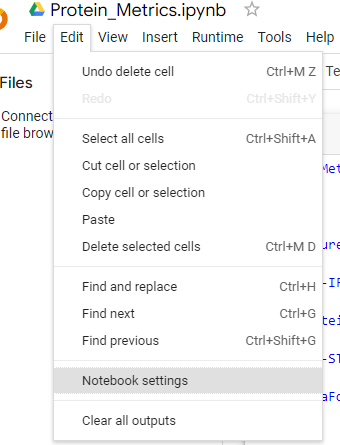

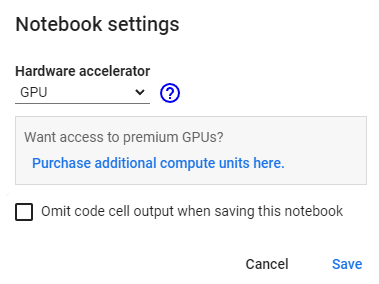